In [1]:
import json
import os
from pathlib import Path

import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import omero.clients
import seaborn as sns
import scanpy as sc
import tifffile
from einops import rearrange
from skimage.segmentation import find_boundaries
from skimage.transform import resize
from skimage.measure import regionprops
from omero.gateway import BlitzGateway

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import mip.utils as utils

## load in data

In [6]:
# os.environ["OMERO_PASSWORD"] = ''

In [7]:
# group = 'HTAN'
# project = 'CODEX_initial'
# username = 'estorrs'
# password = os.environ["OMERO_PASSWORD"]
# host = 'htan-imaging.wucon.wustl.edu'
# port = '4064'

In [8]:
group = 'HTAN'
project = 'CODEX_initial'
username = 'gbm_cell_typing'
password = os.environ["OMERO_PASSWORD"]
host = 'htan-imaging.wucon.wustl.edu'
port = '4064'

In [9]:
conn = BlitzGateway(username, password, host=host, port=port,
                    secure=True, group=group)
conn.connect()

True

In [10]:
project = next(iter(conn.getObjects("Project", attributes={"name": project})))

In [11]:
# list out all images in the project
name_to_img = {}
for dataset in project.listChildren():
    for img in dataset.listChildren():
        name_to_img[f'{dataset.getName()} | {img.getName()}'] = img
sorted(name_to_img.keys())

['E16.5_female_section1_04272023 | E16.5_female_section1_04272023',
 'E16.5_female_section2_04272023 | E16.5_female_section2_04272023',
 'E16.5_male_section1_04272023 | E16.5_male_section1_04272023',
 'E16.5_male_section2_04272023 | E16.5_male_section2_04272023',
 'HS-18-11250-1B_06102023 | HS-18-11250-1B_06102023.ome.tiff',
 'HS-18-6934-2A_06062023 | HS-18-6934-2A_06062023.ome.tiff',
 'HS-19-14816-1J_06062023 | HS-19-14816-1J_06062023.ome.tiff',
 'HS-19-6647-1B_06102023 | HS-19-6647-1B_06102023.ome.tiff',
 'HT110B1_S1H4 | HT110B1_S1H4',
 'HT112C1 | HT112C1',
 'HT171B1-S1H9A1-4_04192023 | HT171B1-S1H9A1-4_04192023',
 'HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff',
 'HT171B1-S1H9A1-4_right_05122023 | HT171B1-S1H9A1-4_right_05122023.ome.tiff',
 'HT171B1-S1H9A1-A4_left_05262023 | HT171B1-S1H9A1-A4_left_05262023.ome.tiff',
 'HT171B1-S1H9A1-A4_right_05262023 | HT171B1-S1H9A1-A4_right_05262023.ome.tiff',
 'HT171B1_S1H1A1_11182022 | HT171B1_S1H1A1_11182022',
 'HT17

In [12]:
names = [
    'HS-18-11250-1B_06102023 | HS-18-11250-1B_06102023.ome.tiff',
    'HS-18-6934-2A_06062023 | HS-18-6934-2A_06062023.ome.tiff',
    'HS-19-14816-1J_06062023 | HS-19-14816-1J_06062023.ome.tiff',
    'HS-19-6647-1B_06102023 | HS-19-6647-1B_06102023.ome.tiff',
]

In [13]:
channel_thresholds = {}
for name in names:
    img = name_to_img[name]
    rendering_defs = img.getAllRenderingDefs()
    channel_metadata = rendering_defs[0]['c']
    thresholds = [c['start'] for c in channel_metadata]
    
    if np.asarray(thresholds).sum() == 0:
        print('warning: all thresholds are zero. maybe they are not set for this image?', name)

    channel_thresholds[name] = thresholds
print('{')
for k in channel_thresholds.keys():
    print(f"'{k}': ")
print('}')
# set(channel_thresholds.keys())

{
'HS-18-11250-1B_06102023 | HS-18-11250-1B_06102023.ome.tiff': 
'HS-18-6934-2A_06062023 | HS-18-6934-2A_06062023.ome.tiff': 
'HS-19-14816-1J_06062023 | HS-19-14816-1J_06062023.ome.tiff': 
'HS-19-6647-1B_06102023 | HS-19-6647-1B_06102023.ome.tiff': 
}


In [25]:
next(iter(channel_thresholds.values()))

[80.0,
 50.0,
 0.0,
 30.0,
 15.0,
 10.0,
 20.0,
 16.0,
 60.0,
 40.0,
 6.0,
 50.0,
 0.0,
 9.0,
 30.0,
 12.0,
 190.0,
 20.0,
 34.0,
 79.0,
 50.0,
 10.0,
 40.0,
 45.0]

In [14]:
conn.close()

In [15]:
ome_fps = sorted(utils.listfiles('/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan',
                                 regex=r'level_2/[^/]+.ome.tiff$'))
seg_fps = sorted(utils.listfiles('/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan',
                                 regex=r'level_3.*cell_seg.*.tif$'))

sample_to_ome = {fp.split('/')[-1].replace('.ome.tiff', '') + '_' + fp.split('/')[-3]:fp for fp in ome_fps}
sample_to_seg = {fp.split('/')[-1].replace('_cell_segmentation.tif', '') + '_' + fp.split('/')[-4]:fp for fp in seg_fps}

for sample in sorted(sample_to_ome.keys()):
    if sample in sample_to_ome and sample in sample_to_seg:
        ome_fp, seg_fp = sample_to_ome[sample], sample_to_seg[sample]
        print('{' + f"'img': '{ome_fp}', 'seg': '{seg_fp}'" + '},')


{'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/06102023_HS-18-11250-1B_TOP_HS-19-6647-1B_BTM/level_2/HS-18-11250-1B_06102023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/06102023_HS-18-11250-1B_TOP_HS-19-6647-1B_BTM/level_3/segmentation/HS-18-11250-1B_06102023_cell_segmentation.tif'},
{'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/06062023_GBM_HS-18-6934-2A_TOP_HS-19-14816-1J_BTM/level_2/HS-18-6934-2A_06062023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/06062023_GBM_HS-18-6934-2A_TOP_HS-19-14816-1J_BTM/level_3/segmentation/HS-18-6934-2A_06062023_cell_segmentation.tif'},
{'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/06062023_GBM_HS-18-6934-2A_TOP_HS-19-14816-1J_BTM/level_2/HS-19-14816-1J_06062023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/06062023_GBM_HS-18-6934-2A_TOP_HS-19-14816-1J_BTM/level_3/segm

In [16]:
mapping = {
'HS-18-11250-1B_06102023 | HS-18-11250-1B_06102023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/06102023_HS-18-11250-1B_TOP_HS-19-6647-1B_BTM/level_2/HS-18-11250-1B_06102023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/06102023_HS-18-11250-1B_TOP_HS-19-6647-1B_BTM/level_3/segmentation/HS-18-11250-1B_06102023_cell_segmentation.tif'},
'HS-18-6934-2A_06062023 | HS-18-6934-2A_06062023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/06062023_GBM_HS-18-6934-2A_TOP_HS-19-14816-1J_BTM/level_2/HS-18-6934-2A_06062023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/06062023_GBM_HS-18-6934-2A_TOP_HS-19-14816-1J_BTM/level_3/segmentation/HS-18-6934-2A_06062023_cell_segmentation.tif'},
'HS-19-14816-1J_06062023 | HS-19-14816-1J_06062023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/06062023_GBM_HS-18-6934-2A_TOP_HS-19-14816-1J_BTM/level_2/HS-19-14816-1J_06062023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/06062023_GBM_HS-18-6934-2A_TOP_HS-19-14816-1J_BTM/level_3/segmentation/HS-19-14816-1J_06062023_cell_segmentation.tif'},
'HS-19-6647-1B_06102023 | HS-19-6647-1B_06102023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/06102023_HS-18-11250-1B_TOP_HS-19-6647-1B_BTM/level_2/HS-19-6647-1B_06102023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/06102023_HS-18-11250-1B_TOP_HS-19-6647-1B_BTM/level_3/segmentation/HS-19-6647-1B_06102023_cell_segmentation.tif'},
}

In [17]:
mapping = {
    'HT434P1_H1 | HT434P1_H1': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/pdac/HT434P1-H1/level_2/HT434P1-H1.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/pdac/HT434P1-H1/level_3/segmentation/HT434P1-H1_cell_segmentation.tif'},
    'S15_1909_A3_Section3_03082023 | S15_1909_A3_Section3_03082023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/crc/20230308_CRC_Primary_S15_1909_A3_Section3/level_2/S15_1909_A3_Section3_03082023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/crc/20230308_CRC_Primary_S15_1909_A3_Section3/level_3/segmentation/S15_1909_A3_Section3_03082023_cell_segmentation.tif'},
    'S15_1909_C2_Section3_03092023 | S15_1909_C2_Section3_03092023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/crc/20230309_CRC_Met_S15_1909_C2_Section3/level_2/S15_1909_C2_Section3_03092023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/crc/20230309_CRC_Met_S15_1909_C2_Section3/level_3/segmentation/S15_1909_C2_Section3_03092023_cell_segmentation.tif'},
}

In [17]:
mapping = {
    'HT342C1_Th1K4A1_section1_03042022 | HT342C1_Th1K4A1_section1_03042022': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/crc/20230304_Liver_mCRC_SenNet_HT342C1_HT347C1/level_2/HT342C1_Th1K4A1_section1_03042022.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/crc/20230304_Liver_mCRC_SenNet_HT342C1_HT347C1/level_3/segmentation/HT342C1_Th1K4A1_section1_03042022_cell_segmentation.tif'},
    'HT342C1_Th1K4A1_section2_03042022 | HT342C1_Th1K4A1_section2_03042022': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/crc/20230304_Liver_mCRC_SenNet_HT342C1_HT347C1/level_2/HT342C1_Th1K4A1_section2_03042022.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/crc/20230304_Liver_mCRC_SenNet_HT342C1_HT347C1/level_3/segmentation/HT342C1_Th1K4A1_section2_03042022_cell_segmentation.tif'},
    'HT347C1_Th1K2A1_section1_03042022 | HT347C1_Th1K2A1_section1_03042022': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/crc/20230304_Liver_mCRC_SenNet_HT342C1_HT347C1/level_2/HT347C1_Th1K2A1_section1_03042022.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/crc/20230304_Liver_mCRC_SenNet_HT342C1_HT347C1/level_3/segmentation/HT347C1_Th1K2A1_section1_03042022_cell_segmentation.tif'},
    'HT347C1_Th1K2A1_section2_03042022 | HT347C1_Th1K2A1_section2_03042022': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/crc/20230304_Liver_mCRC_SenNet_HT342C1_HT347C1/level_2/HT347C1_Th1K2A1_section2_03042022.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/crc/20230304_Liver_mCRC_SenNet_HT342C1_HT347C1/level_3/segmentation/HT347C1_Th1K2A1_section2_03042022_cell_segmentation.tif'},
    'HT413C1-K2_04262023 | HT413C1-K2_04262023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/042623_MULTIPLE_HTAN_HT413C1-K2_TOP_HT339B2-H1_HT553P1-H2_HT565B1-H2_BTM/level_2/HT413C1-K2_04262023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/042623_MULTIPLE_HTAN_HT413C1-K2_TOP_HT339B2-H1_HT553P1-H2_HT565B1-H2_BTM/level_3/segmentation/HT413C1-K2_04262023_cell_segmentation.tif'},
    'HT427P1_S1H1A3_20221020 | HT427P1_S1H1A3_20221020': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT206B1-S1H2L4_and_HT427P1_S1H1A3/level_2/HT427P1_S1H1A3.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT206B1-S1H2L4_and_HT427P1_S1H1A3/level_3/segmentation/HT427P1_S1H1A3_cell_segmentation.tif'},
#     'HT434P1_H1 | HT434P1_H1': 
    'HT488C1-Th1K1Fp1-U14_041823 | HT488C1-Th1K1Fp1-U14_041823': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/crc/041823_CRC_HT488C1-Th1K1Fp1-U14/level_2/HT488C1-Th1K1Fp1-U14_041823.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/crc/041823_CRC_HT488C1-Th1K1Fp1-U14/level_3/segmentation/HT488C1-Th1K1Fp1-U14_041823_cell_segmentation.tif'},
    'HT488C1-Th1K1Fp1-U2_041323 | HT488C1-Th1K1Fp1-U2_041323': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/crc/041323_CRC_HT488C1-Th1K1Fp1-U2/level_2/HT488C1-Th1K1Fp1-U2_041323.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/crc/041323_CRC_HT488C1-Th1K1Fp1-U2/level_3/segmentation/HT488C1-Th1K1Fp1-U2_041323_cell_segmentation.tif'},
    'HT553P1-H2_04262023 | HT553P1-H2_04262023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/042623_MULTIPLE_HTAN_HT413C1-K2_TOP_HT339B2-H1_HT553P1-H2_HT565B1-H2_BTM/level_2/HT553P1-H2_04262023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/042623_MULTIPLE_HTAN_HT413C1-K2_TOP_HT339B2-H1_HT553P1-H2_HT565B1-H2_BTM/level_3/segmentation/HT553P1-H2_04262023_cell_segmentation.tif'},
}

In [16]:
mapping = {
    'HT110B1_S1H4 | HT110B1_S1H4': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT243B1-S1H4_HT110B1-S1H4_HT305B1-S1H1/level_2/HT110B1-S1H4.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT243B1-S1H4_HT110B1-S1H4_HT305B1-S1H1/level_3/segmentation/HT110B1-S1H4_cell_segmentation.tif'},
    'HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT171B1-S1H9A1-4_left_05122023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_3/segmentation/HT171B1-S1H9A1-4_left_05122023_cell_segmentation.tif'},
    'HT171B1-S1H9A1-4_right_05122023 | HT171B1-S1H9A1-4_right_05122023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT171B1-S1H9A1-4_right_05122023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_3/segmentation/HT171B1-S1H9A1-4_right_05122023_cell_segmentation.tif'},
    'HT206B1_H1 | HT206B1_H1': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT206B1-H1/level_2/HT206B1-H1.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT206B1-H1/level_3/segmentation/HT206B1-H1_cell_segmentation.tif'},
    'HT206B1_H1_06252022 | HT206B1_H1_06252022': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT206B1_H1_06252022/level_2/HT206B1_H1_06252022.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT206B1_H1_06252022/level_3/segmentation/HT206B1_H1_06252022_cell_segmentation.tif'},
#     'HT206B1_S1H2L4_20221020 | HT206B1_S1H2L4_20221020': 
    'HT206B1_S1H2L4_20221028 | HT206B1_S1H2L4_20221028': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT206B1-S1H2L4_LRG_HT427P1_S1H1A3_SML_20221028/level_2/HT206B1_S1H2L4.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT206B1-S1H2L4_LRG_HT427P1_S1H1A3_SML_20221028/level_3/segmentation/HT206B1_S1H2L4_cell_segmentation.tif'},
    'HT243B1-S1H4A4_04192023 | HT243B1-S1H4A4_04192023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_2/HT243B1-S1H4A4_04192023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_3/segmentation/HT243B1-S1H4A4_04192023_cell_segmentation.tif'},
    'HT243B1-S1H4A4_left_05122023 | HT243B1-S1H4A4_left_05122023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT243B1-S1H4A4_left_05122023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_3/segmentation/HT243B1-S1H4A4_left_05122023_cell_segmentation.tif'},
    'HT243B1-S1H4A4_right_05122023 | HT243B1-S1H4A4_right_05122023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT243B1-S1H4A4_right_05122023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_3/segmentation/HT243B1-S1H4A4_right_05122023_cell_segmentation.tif'},
    'HT243B1_S1H4 | HT243B1_S1H4': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT243B1-S1H4_HT110B1-S1H4_HT305B1-S1H1/level_2/HT243B1-S1H4.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT243B1-S1H4_HT110B1-S1H4_HT305B1-S1H1/level_3/segmentation/HT243B1-S1H4_cell_segmentation.tif'},
    'HT271B1-S1H6A5_04192023 | HT271B1-S1H6A5_04192023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_2/HT271B1-S1H6A5_04192023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_3/segmentation/HT271B1-S1H6A5_04192023_cell_segmentation.tif'},
    'HT271B1-S1H6A5_left_05122023 | HT271B1-S1H6A5_left_05122023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT271B1-S1H6A5_left_05122023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_3/segmentation/HT271B1-S1H6A5_left_05122023_cell_segmentation.tif'},
    'HT271B1-S1H6A5_right_05122023 | HT271B1-S1H6A5_right_05122023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT271B1-S1H6A5_right_05122023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_3/segmentation/HT271B1-S1H6A5_right_05122023_cell_segmentation.tif'},
    'HT271B1_S1H3A5_02172023 | HT271B1_S1H3A5_02172023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/021723_BCRA_HT271B1_S1H3A5/level_2/HT271B1_S1H3A5.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/021723_BCRA_HT271B1_S1H3A5/level_3/segmentation/HT271B1_S1H3A5_cell_segmentation.tif'},
#     'HT297B1_H1_08042022 | HT297B1_H1_08042022': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT297B1-H1-08042022/level_2/HT297B1-H1-08042022.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT297B1-H1-08042022/level_3/segmentation/HT297B1-H1-08042022_cell_segmentation.tif'},
    'HT305B1_S1H1 | HT305B1_S1H1': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT243B1-S1H4_HT110B1-S1H4_HT305B1-S1H1/level_2/HT305B1-S1H1.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT243B1-S1H4_HT110B1-S1H4_HT305B1-S1H1/level_3/segmentation/HT305B1-S1H1_cell_segmentation.tif'},
    'HT308B1-S1H5A4_04192023 | HT308B1-S1H5A4_04192023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_2/HT308B1-S1H5A4_04192023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_3/segmentation/HT308B1-S1H5A4_04192023_cell_segmentation.tif'},
    'HT308B1-S1H5A4_left_05122023 | HT308B1-S1H5A4_left_05122023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT308B1-S1H5A4_left_05122023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_3/segmentation/HT308B1-S1H5A4_left_05122023_cell_segmentation.tif'},
    'HT308B1-S1H5A4_right_05122023 | HT308B1-S1H5A4_right_05122023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT308B1-S1H5A4_right_05122023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_3/segmentation/HT308B1-S1H5A4_right_05122023_cell_segmentation.tif'},
    'HT323B1_H1A1 | HT323B1_H1A1': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT323B1-H1A1/level_2/HT323B1-H1A1.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT323B1-H1A1/level_3/segmentation/HT323B1-H1A1_cell_segmentation.tif'},
    'HT323B1_H1A4 | HT323B1_H1A4': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT323B1-H1A4/level_2/HT323B1-H1A4.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT323B1-H1A4/level_3/segmentation/HT323B1-H1A4_cell_segmentation.tif'},
    'HT323B1_H1_08042022 | HT323B1_H1_08042022': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT323B1-H1-08042022/level_2/HT323B1-H1-08042022.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT323B1-H1-08042022/level_3/segmentation/HT323B1-H1-08042022_cell_segmentation.tif'},
    'HT323B1_H3 | HT323B1_H3': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT323B1-H3/level_2/HT323B1-H3.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT323B1-H3/level_3/segmentation/HT323B1-H3_cell_segmentation.tif'},
    'HT339B1_H1A1 | HT339B1_H1A1': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT339B1-H1A1/level_2/HT339B1-H1A1.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT339B1-H1A1/level_3/segmentation/HT339B1-H1A1_cell_segmentation.tif'},
    'HT339B1_H2A1 | HT339B1_H2A1': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT339B1-H2A1/level_2/HT339B1-H2A1.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT339B1-H2A1/level_3/segmentation/HT339B1-H2A1_cell_segmentation.tif'},
#     'HT339B1_H4A4 | HT339B1_H4A4': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT339B1-H4A4/level_2/HT339B1-H4A4.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT339B1-H4A4/level_3/segmentation/HT339B1-H4A4_cell_segmentation.tif'},
    'HT365B1_S1H1_02132023 | HT365B1_S1H1_02132023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/021323_BRCA_HT365B1_S1H1/level_2/HT365B1_S1H1.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/021323_BRCA_HT365B1_S1H1/level_3/segmentation/HT365B1_S1H1_cell_segmentation.tif'},
    'HT397B1_H2A2 | HT397B1_H2A2': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT397B1-H2A2/level_2/HT397B1-H2A2.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT397B1-H2A2/level_3/segmentation/HT397B1-H2A2_cell_segmentation.tif'},
    'HT397B1_H3A1 | HT397B1_H3A1': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT397B1-H3A1/level_2/HT397B1-H3A1.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT397B1-H3A1/level_3/segmentation/HT397B1-H3A1_cell_segmentation.tif'},
    'HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22_04122023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041223_BRCA_HT397B1-S1H3A1-U22/level_2/HT397B1_S1H1A3U22_04122023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041223_BRCA_HT397B1-S1H3A1-U22/level_3/segmentation/HT397B1_S1H1A3U22_04122023_cell_segmentation.tif'},
    'HT397B1_S1H1A3U31_04062023 | HT397B1_S1H1A3U31_04062023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/040623_BRCA_HT397B1-U31/level_2/HT397B1_S1H1A3U31_04062023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/040623_BRCA_HT397B1-U31/level_3/segmentation/HT397B1_S1H1A3U31_04062023_cell_segmentation.tif'},
    'HT397B1_U12_03172023 | HT397B1_U12_03172023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_2/HT397B1_U12_03172023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_3/segmentation/HT397B1_U12_03172023_cell_segmentation.tif'},
    'HT397B1_U2_03162023 | HT397B1_U2_03162023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/031623_BRCA_HT397B1-U2/level_2/HT397B1_U2_03162023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/031623_BRCA_HT397B1-U2/level_3/segmentation/HT397B1_U2_03162023_cell_segmentation.tif'},
    'HT480B1_S1H2_R001 | HT480B1_S1H2_R001': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT480B1-S1H2_reg001/level_2/HT480B1-S1H2-R001.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT480B1-S1H2_reg001/level_3/segmentation/HT480B1-S1H2-R001_cell_segmentation.tif'},
    'HT480B1_S1H2_R002 | HT480B1_S1H2_R002': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT480B1-S1H2_reg002/level_2/HT480B1-S1H2-R002.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT480B1-S1H2_reg002/level_3/segmentation/HT480B1-S1H2-R002_cell_segmentation.tif'},
    'HT565B1-H2_04262023 | HT565B1-H2_04262023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/042623_MULTIPLE_HTAN_HT413C1-K2_TOP_HT339B2-H1_HT553P1-H2_HT565B1-H2_BTM/level_2/HT565B1-H2_04262023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/042623_MULTIPLE_HTAN_HT413C1-K2_TOP_HT339B2-H1_HT553P1-H2_HT565B1-H2_BTM/level_3/segmentation/HT565B1-H2_04262023_cell_segmentation.tif'},
}


In [17]:
channel_mapping = utils.CHANNEL_MAPPING
r_channel_mapping = {v:k for k, vs in channel_mapping.items() for v in vs}

In [18]:
def generate_feature_table(ome_fp, seg_fp, thresholds):
    print('extracting ome.tiff')
    channels, imgs = utils.extract_ome_tiff(ome_fp, as_dict=False)
    print(channels, imgs.shape)
    assert len(channels) == len(thresholds)
    
    seg = tifffile.imread(seg_fp)
    thresholds = np.asarray(thresholds) # make sure numpy
    
    masks = rearrange(
        rearrange(imgs, 'c h w -> h w c') > thresholds,
        'h w c -> c h w')
    
    props = regionprops(seg)
    print('num props', len(props))
    
    data = []
    for i, prop in enumerate(props):
        label = i + 1
        row = []
        r1, c1, r2, c2 = prop['bbox']

        area = prop['area']
        seg_tile = seg[r1:r2, c1:c2]
        imgs_tile = imgs[..., r1:r2, c1:c2]
        masks_tile = masks[..., r1:r2, c1:c2]

        cell_mask = seg_tile==label
        
#         if i % 10000 == 0:
#             print(i)
#             print(r1, r2, c1, c2)
#             plt.imshow(cell_mask)
#             plt.show()

        row = [label, prop['centroid'][0], prop['centroid'][1], r1, c1, r2, c2, area]
        for j in range(imgs_tile.shape[0]):
            img, mask = imgs_tile[j], masks_tile[j]
            counts = (cell_mask & mask).sum()
            row.append(counts / area)
            
            intensity = img[cell_mask].mean()
            row.append(intensity)

        data.append(row)

    cols = ['label', 'row', 'col', 'bbox-r1', 'bbox-c1', 'bbox-r2', 'bbox-c2', 'area']
    for c in channels:
        converted = r_channel_mapping.get(c, c)
        for identifier in ['fraction', 'intensity']:
            cols.append(f'{converted}_{identifier}')
    df = pd.DataFrame(data=data, columns=cols)
    return df


In [19]:
name_to_features = {}
for name in mapping.keys():
    print(name)
    df = generate_feature_table(mapping[name]['img'], mapping[name]['seg'], channel_thresholds[name])
    name_to_features[name] = df

HS-18-11250-1B_06102023 | HS-18-11250-1B_06102023.ome.tiff
extracting ome.tiff
['DAPI', 'Podoplanin', 'Pan-Cytokeratin', 'HLA-DR', 'CD8', 'TUBB3 (D)', 'CD45', 'Ki67', 'Vimentin-(D)', 'GLUT1-(D)', 'PTPRZ1 (D)', 'CD3e', 'HIF1a (D)', 'CD31', 'CD11b (D)', 'PAI1-(D)', 'GFAP (D)', 'VEGFA (D)', 'CD68', 'IBA1 (D)', 'OLIG2 (D)', 'FN1', 'CD4 (D)', 'CD20 (D)'] (24, 31000, 25920)
num props 585926
HS-18-6934-2A_06062023 | HS-18-6934-2A_06062023.ome.tiff
extracting ome.tiff
['DAPI', 'Podoplanin', 'Pan-Cytokeratin', 'HLA-DR', 'CD8', 'TUBB3 (D)', 'CD45', 'Ki67', 'Vimentin-(D)', 'GLUT1-(D)', 'PTPRZ1 (D)', 'CD3e', 'HIF1a (D)', 'CD31', 'CD11b (D)', 'PAI1-(D)', 'GFAP (D)', 'VEGFA (D)', 'CD68', 'IBA1 (D)', 'OLIG2 (D)', 'FN1', 'CD4 (D)', 'CD20 (D)'] (24, 15000, 21120)
num props 340825
HS-19-14816-1J_06062023 | HS-19-14816-1J_06062023.ome.tiff
extracting ome.tiff
['DAPI', 'Podoplanin', 'Pan-Cytokeratin', 'HLA-DR', 'CD8', 'TUBB3 (D)', 'CD45', 'Ki67', 'Vimentin-(D)', 'GLUT1-(D)', 'PTPRZ1 (D)', 'CD3e', 'HIF1a (

In [21]:
mapping.keys()

dict_keys(['HT342C1_Th1K4A1_section1_03042022 | HT342C1_Th1K4A1_section1_03042022', 'HT342C1_Th1K4A1_section2_03042022 | HT342C1_Th1K4A1_section2_03042022', 'HT347C1_Th1K2A1_section1_03042022 | HT347C1_Th1K2A1_section1_03042022', 'HT347C1_Th1K2A1_section2_03042022 | HT347C1_Th1K2A1_section2_03042022', 'HT413C1-K2_04262023 | HT413C1-K2_04262023', 'HT427P1_S1H1A3_20221020 | HT427P1_S1H1A3_20221020', 'HT488C1-Th1K1Fp1-U14_041823 | HT488C1-Th1K1Fp1-U14_041823', 'HT488C1-Th1K1Fp1-U2_041323 | HT488C1-Th1K1Fp1-U2_041323', 'HT553P1-H2_04262023 | HT553P1-H2_04262023'])

In [22]:
# channel_thresholds['HT110B1_S1H4 | HT110B1_S1H4']

In [21]:
default = .05
gating_strategy = [
    {
        'name': 'Epithelial',
        'strategy': [
            {'channel': 'Pan-Cytokeratin', 'value': default, 'direction': 'pos'}
        ],
    },
    {
        'name': 'Epithelial',
        'strategy': [
            {'channel': 'E-cadherin', 'value': default, 'direction': 'pos'}
        ],
    },
    {
        'name': 'Treg',
        'strategy': [
            {'channel': 'CD3e', 'value': default, 'direction': 'pos'},
            {'channel': 'CD4', 'value': default, 'direction': 'pos'},
            {'channel': 'FOXP3', 'value': default, 'direction': 'pos'}
        ],
    },
    {
        'name': 'CD4 T cell',
        'strategy': [
            {'channel': 'CD3e', 'value': default, 'direction': 'pos'},
            {'channel': 'CD4', 'value': default, 'direction': 'pos'},
        ],
    },
    {
        'name': 'CD8 T cell',
        'strategy': [
#             {'channel': 'CD3e', 'value': default, 'direction': 'pos'},
            {'channel': 'CD8', 'value': default, 'direction': 'pos'}
        ],
    },
    {
        'name': 'B cell',
        'strategy': [
            {'channel': 'CD20', 'value': default, 'direction': 'pos'}
        ],
    },
    {
        'name': 'Macrophage - M1',
        'strategy': [
            {'channel': 'CD68', 'value': default, 'direction': 'pos'}
        ],
    },
    {
        'name': 'Macrophage - M2',
        'strategy': [
            {'channel': 'CD68', 'value': default, 'direction': 'pos'},
            {'channel': 'CD163', 'value': default, 'direction': 'pos'}
        ],
    },
    {
        'name': 'Endothelial',
        'strategy': [
            {'channel': 'CD31', 'value': default, 'direction': 'pos'},
        ],
    },
    {
        'name': 'Immune',
        'strategy': [
            {'channel': 'CD45', 'value': default, 'direction': 'pos'},
        ],
    },
    {
        'name': 'Immune',
        'strategy': [
            {'channel': 'CD3e', 'value': default, 'direction': 'pos'},
        ],
    },
    {
        'name': 'Immune',
        'strategy': [
            {'channel': 'CD4', 'value': default, 'direction': 'pos'},
        ],
    },
    {
        'name': 'Immune',
        'strategy': [
            {'channel': 'CD68', 'value': default, 'direction': 'pos'},
        ],
    },
    {
        'name': 'Immune',
        'strategy': [
            {'channel': 'CD163', 'value': default, 'direction': 'pos'},
        ],
    },
    {
        'name': 'Stroma',
        'strategy': [
            {'channel': 'SMA', 'value': default, 'direction': 'pos'},
        ],
    },
    {
        'name': 'Stroma',
        'strategy': [
            {'channel': 'Podoplanin', 'value': default, 'direction': 'pos'},
        ],
    },
]

In [22]:


for name, df in name_to_features.items():
    markers = [c.replace('_fraction', '') for c in df.columns if '_fraction' in c]
    print(markers)
    cell_types = np.asarray(['Unlabeled'] * df.shape[0], dtype=object)
    for d in gating_strategy:
        is_valid = cell_types=='Unlabeled'
        mask = np.ones_like(cell_types, dtype=np.bool)
        for strategy in d['strategy']:
            channel, val = strategy['channel'], strategy['value']
            threshold = channel_thresholds[name][markers.index(channel)] if channel in markers else 0
            x = df[f'{channel}_fraction'].to_list()[0] if f'{channel}_fraction' in df.columns else 0
            print(name, threshold, x)
            if pd.isnull(x) or threshold==0:
                if len(d) == 1:
                    m = np.ones_like(mask, dtype=np.bool)
                else:
                    m = np.zeros_like(mask, dtype=np.bool)
            elif strategy['direction'] == 'pos': 
                m = df[f'{channel}_fraction'] >= val
            else:
                m = df[f'{channel}_fraction'] < val
            mask &= m

        if ~mask.sum() == 0: # if all true then pass bc that means marker isn't present or something is wrong with gate
            pass
        else:
            mask &= is_valid
            cell_types[mask] = d['name']
    df['cell_type'] = cell_types
    name_to_features[name] = df

['DAPI', 'Podoplanin', 'Pan-Cytokeratin', 'HLA-DR', 'CD8', 'TUBB3', 'CD45', 'Ki67', 'Vimentin', 'GLUT1', 'PTPRZ1', 'CD3e', 'HIF1a', 'CD31', 'CD11b', 'PAI1', 'GFAP', 'VEGFA', 'CD68', 'IBA1', 'OLIG2', 'FN1', 'CD4', 'CD20']
HS-18-11250-1B_06102023 | HS-18-11250-1B_06102023.ome.tiff 0.0 1.0
HS-18-11250-1B_06102023 | HS-18-11250-1B_06102023.ome.tiff 0 0
HS-18-11250-1B_06102023 | HS-18-11250-1B_06102023.ome.tiff 50.0 0.0
HS-18-11250-1B_06102023 | HS-18-11250-1B_06102023.ome.tiff 40.0 0.0
HS-18-11250-1B_06102023 | HS-18-11250-1B_06102023.ome.tiff 0 0
HS-18-11250-1B_06102023 | HS-18-11250-1B_06102023.ome.tiff 50.0 0.0
HS-18-11250-1B_06102023 | HS-18-11250-1B_06102023.ome.tiff 40.0 0.0
HS-18-11250-1B_06102023 | HS-18-11250-1B_06102023.ome.tiff 15.0 0.0


/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys
/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


HS-18-11250-1B_06102023 | HS-18-11250-1B_06102023.ome.tiff 45.0 0.0
HS-18-11250-1B_06102023 | HS-18-11250-1B_06102023.ome.tiff 34.0 0.0
HS-18-11250-1B_06102023 | HS-18-11250-1B_06102023.ome.tiff 34.0 0.0
HS-18-11250-1B_06102023 | HS-18-11250-1B_06102023.ome.tiff 0 0
HS-18-11250-1B_06102023 | HS-18-11250-1B_06102023.ome.tiff 9.0 0.0
HS-18-11250-1B_06102023 | HS-18-11250-1B_06102023.ome.tiff 20.0 0.0
HS-18-11250-1B_06102023 | HS-18-11250-1B_06102023.ome.tiff 50.0 0.0
HS-18-11250-1B_06102023 | HS-18-11250-1B_06102023.ome.tiff 40.0 0.0
HS-18-11250-1B_06102023 | HS-18-11250-1B_06102023.ome.tiff 34.0 0.0
HS-18-11250-1B_06102023 | HS-18-11250-1B_06102023.ome.tiff 0 0
HS-18-11250-1B_06102023 | HS-18-11250-1B_06102023.ome.tiff 0 0
HS-18-11250-1B_06102023 | HS-18-11250-1B_06102023.ome.tiff 50.0 0.0
['DAPI', 'Podoplanin', 'Pan-Cytokeratin', 'HLA-DR', 'CD8', 'TUBB3', 'CD45', 'Ki67', 'Vimentin', 'GLUT1', 'PTPRZ1', 'CD3e', 'HIF1a', 'CD31', 'CD11b', 'PAI1', 'GFAP', 'VEGFA', 'CD68', 'IBA1', 'OLIG2', '

In [31]:
# combined = None
# for name, df in name_to_features.items():
#     df['name'] = name
#     if combined is None:
#         combined = df
#     else:
#         combined = pd.concat((combined, df))
# combined

In [28]:
order = sorted({d['name'] for d in gating_strategy})
order.append('Unlabeled')

order

['B cell',
 'CD4 T cell',
 'CD8 T cell',
 'Endothelial',
 'Epithelial',
 'Immune',
 'Macrophage - M1',
 'Macrophage - M2',
 'Stroma',
 'Treg',
 'Unlabeled']

In [23]:
name_to_features.keys()

dict_keys(['HS-18-11250-1B_06102023 | HS-18-11250-1B_06102023.ome.tiff', 'HS-18-6934-2A_06062023 | HS-18-6934-2A_06062023.ome.tiff', 'HS-19-14816-1J_06062023 | HS-19-14816-1J_06062023.ome.tiff', 'HS-19-6647-1B_06102023 | HS-19-6647-1B_06102023.ome.tiff'])

In [24]:
next(iter(name_to_features.values()))

,label,row,col,bbox-r1,bbox-c1,bbox-r2,bbox-c2,area,DAPI_fraction,DAPI_intensity,...,IBA1_intensity,OLIG2_fraction,OLIG2_intensity,FN1_fraction,FN1_intensity,CD4_fraction,CD4_intensity,CD20_fraction,CD20_intensity,cell_type
0,1,3.518750,11556.793750,0,11547,9,11568,160,0.0,20.312500,...,0.181250,0.0,1.368750,0.0,0.162500,0.0,0.981250,0.0,0.712500,Unlabeled
1,2,6.173653,11605.236527,0,11591,14,11621,334,0.0,13.038922,...,0.203593,0.0,0.682635,0.0,0.209581,0.0,0.832335,0.0,0.401198,Unlabeled
2,3,4.670157,11762.701571,0,11753,11,11773,191,0.0,16.502618,...,0.246073,0.0,0.806283,0.0,0.146597,0.0,0.905759,0.0,0.455497,Unlabeled
3,4,5.121053,11805.857895,0,11797,12,11816,190,0.0,13.589474,...,0.484211,0.0,0.815789,0.0,0.189474,0.0,1.131579,0.0,0.510526,Unlabeled
4,5,2.822581,11925.387097,0,11921,7,11931,62,0.0,13.919355,...,0.467742,0.0,0.919355,0.0,0.419355,0.0,1.225806,0.0,0.516129,Unlabeled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585921,585922,30256.208423,18179.826134,30238,18122,30274,18236,2778,0.0,5.886249,...,0.228582,0.0,0.960763,0.0,0.113391,0.0,1.086393,0.0,0.472642,Unlabeled
585922,585923,30256.553972,17986.572141,30239,17932,30274,18043,2807,0.0,5.656217,...,0.213395,0.0,0.789455,0.0,0.122195,0.0,0.912362,0.0,0.369077,Unlabeled
585923,585924,30256.558309,19481.769193,30241,19444,30275,19525,2058,0.0,6.119048,...,0.191448,0.0,2.191934,0.0,0.124393,0.0,2.965986,0.0,1.773081,Unlabeled
585924,585925,30257.801587,15908.506614,30247,15880,30269,15934,756,0.0,5.390212,...,0.294974,0.0,0.523810,0.0,0.119048,0.0,0.812169,0.0,0.194444,Unlabeled


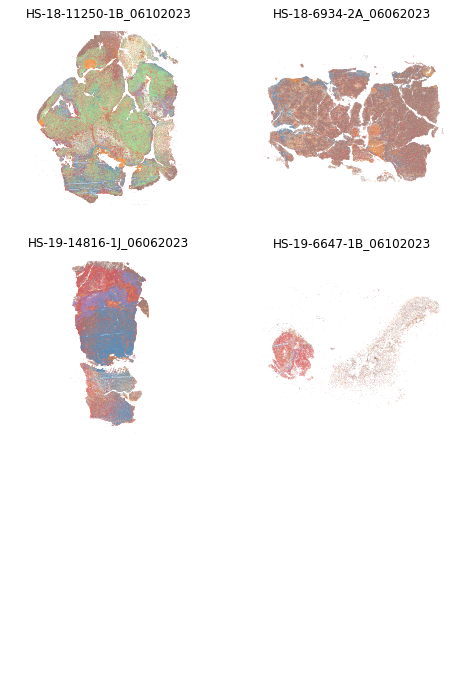

In [29]:
ncols = 2
nrows = (len(name_to_features) // ncols) + 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 4, nrows * 4))

queue = sorted(name_to_features.keys())
for i in range(nrows):
    for j in range(ncols):
        ax = axs[i, j]
        if len(queue):
            name = queue.pop(0)
            f = name_to_features[name]
            sns.scatterplot(data=f, x='col', y='row', hue='cell_type', s=.1, hue_order=order,
                            ax=ax, palette='tab20')
            ax.invert_yaxis()
            ax.axis('equal')
            ax.axis('off')
            ax.set_title(name.split(' | ')[0])

            leg = ax.get_legend()
            if leg is not None:
                leg.remove()
            
    
        else:
            ax.axis('off')
            
            

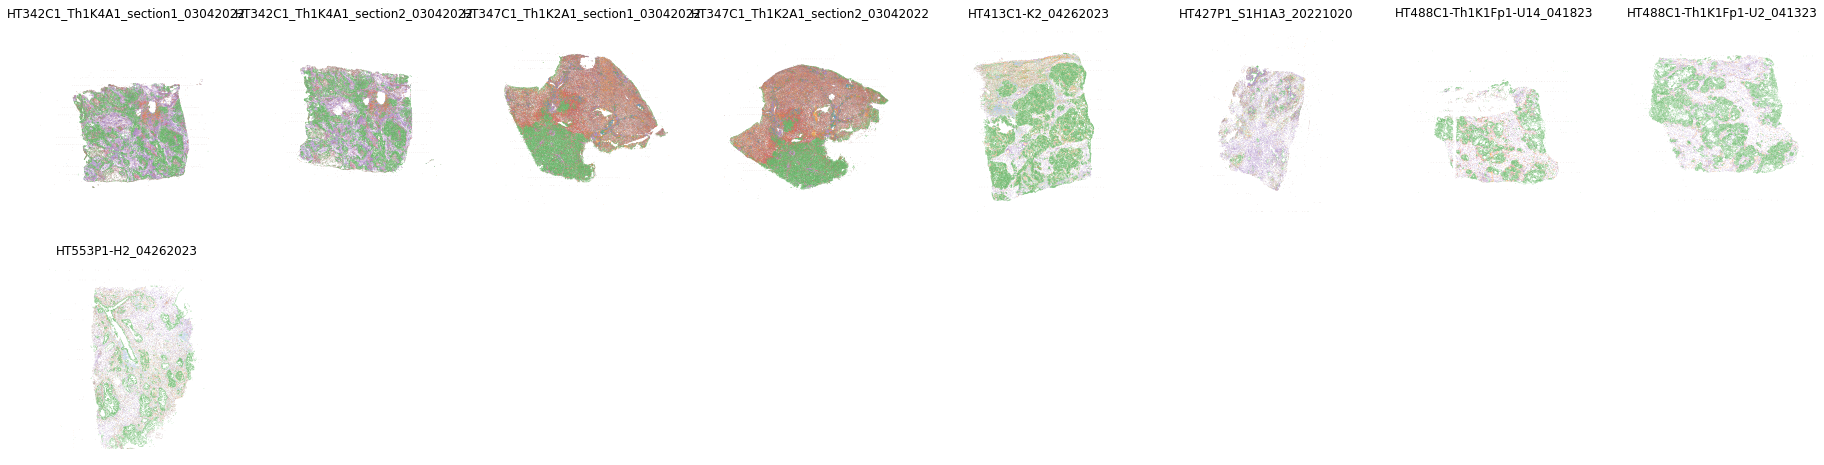

In [30]:
ncols = 8
nrows = (len(name_to_features) // ncols) + 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 4, nrows * 4))

queue = sorted(name_to_features.keys())
for i in range(nrows):
    for j in range(ncols):
        ax = axs[i, j]
        if len(queue):
            name = queue.pop(0)
            f = name_to_features[name]
            sns.scatterplot(data=f, x='col', y='row', hue='cell_type', s=.1, hue_order=order,
                            ax=ax, palette='tab20')
            ax.invert_yaxis()
            ax.axis('equal')
            ax.axis('off')
            ax.set_title(name.split(' | ')[0])

            leg = ax.get_legend()
            if leg is not None:
                leg.remove()
            
    
        else:
            ax.axis('off')
            
            

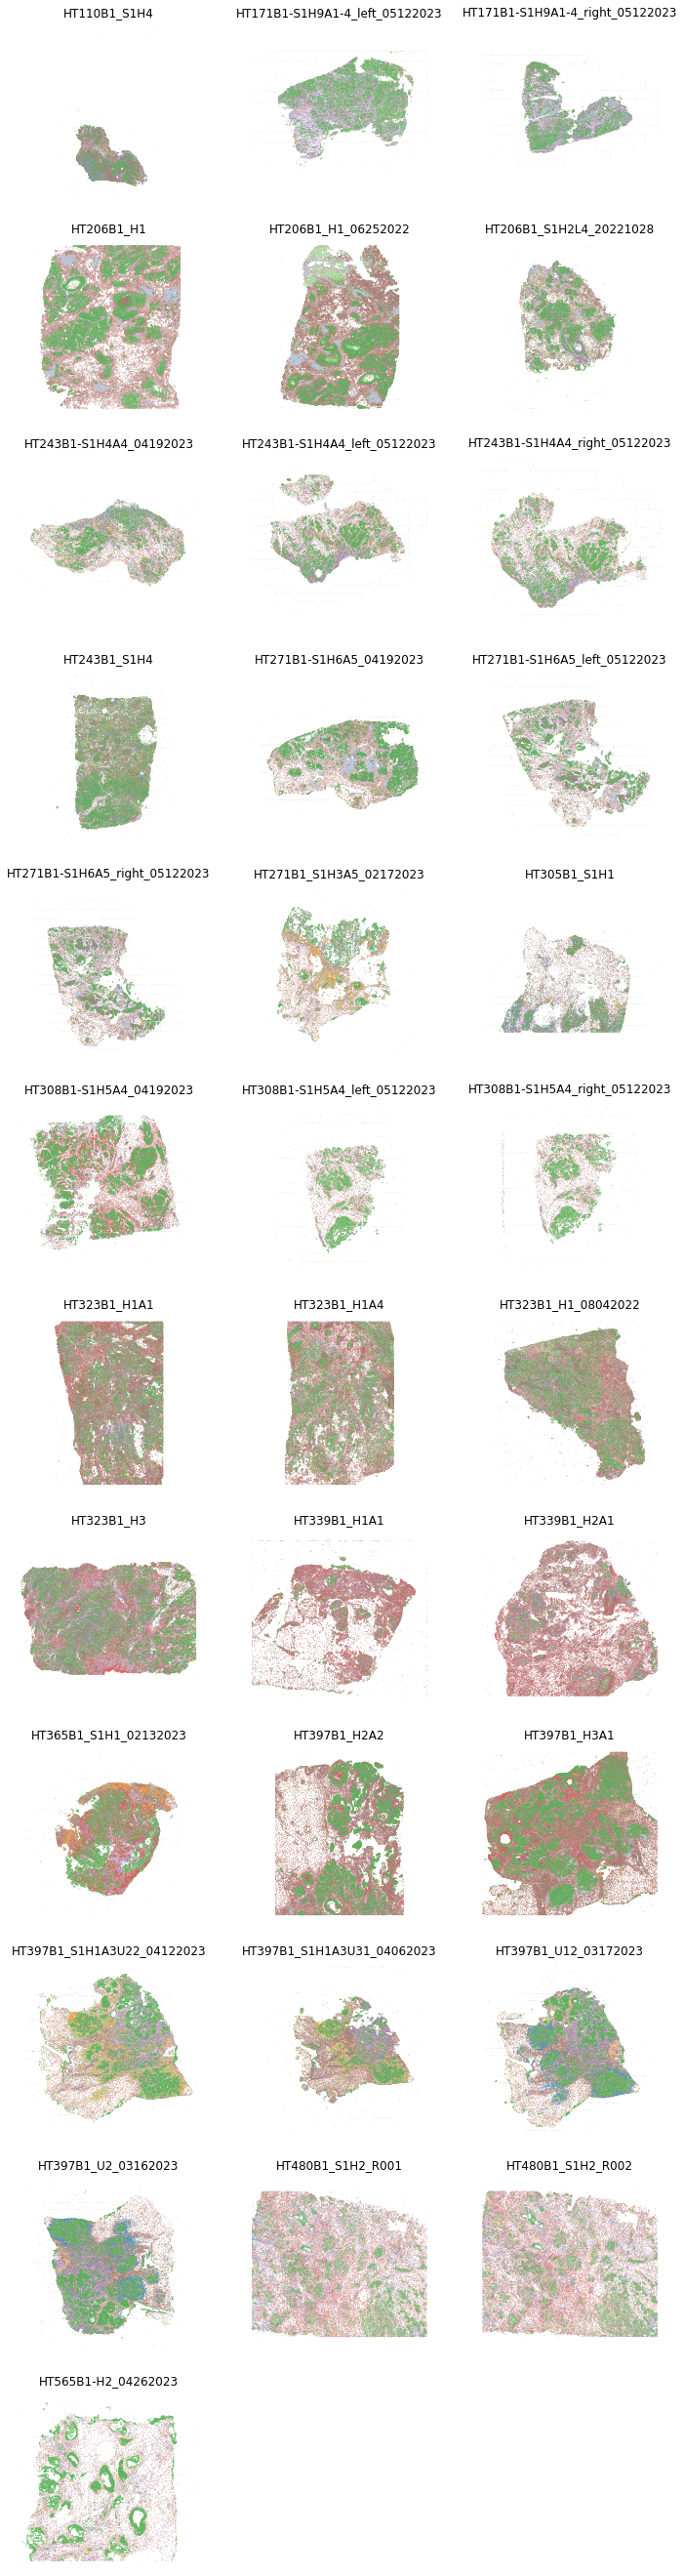

In [42]:
ncols = 3
nrows = (len(name_to_features) // ncols) + 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 4, nrows * 4))

queue = sorted(name_to_features.keys())
for i in range(nrows):
    for j in range(ncols):
        ax = axs[i, j]
        if len(queue):
            name = queue.pop(0)
            f = name_to_features[name]
            sns.scatterplot(data=f, x='col', y='row', hue='cell_type', s=.1, hue_order=order,
                            ax=ax, palette='tab20')
            ax.invert_yaxis()
            ax.axis('equal')
            ax.axis('off')
            ax.set_title(name.split(' | ')[0])

            leg = ax.get_legend()
            if leg is not None:
                leg.remove()
            
    
        else:
            ax.axis('off')
            
            

In [31]:
list(name_to_features.keys())

['HT342C1_Th1K4A1_section1_03042022 | HT342C1_Th1K4A1_section1_03042022',
 'HT342C1_Th1K4A1_section2_03042022 | HT342C1_Th1K4A1_section2_03042022',
 'HT347C1_Th1K2A1_section1_03042022 | HT347C1_Th1K2A1_section1_03042022',
 'HT347C1_Th1K2A1_section2_03042022 | HT347C1_Th1K2A1_section2_03042022',
 'HT413C1-K2_04262023 | HT413C1-K2_04262023',
 'HT427P1_S1H1A3_20221020 | HT427P1_S1H1A3_20221020',
 'HT488C1-Th1K1Fp1-U14_041823 | HT488C1-Th1K1Fp1-U14_041823',
 'HT488C1-Th1K1Fp1-U2_041323 | HT488C1-Th1K1Fp1-U2_041323',
 'HT553P1-H2_04262023 | HT553P1-H2_04262023']

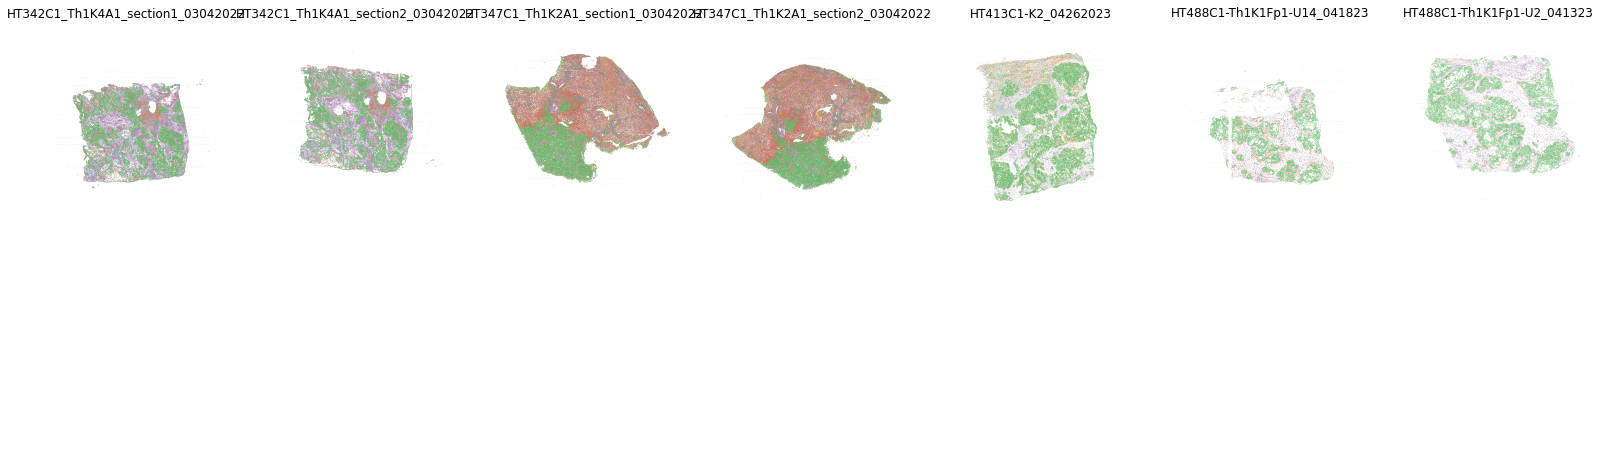

In [32]:


ncols = 7
nrows = (len(name_to_features) // ncols) + 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 4, nrows * 4))

queue = ['HT342C1_Th1K4A1_section1_03042022 | HT342C1_Th1K4A1_section1_03042022',
 'HT342C1_Th1K4A1_section2_03042022 | HT342C1_Th1K4A1_section2_03042022',
 'HT347C1_Th1K2A1_section1_03042022 | HT347C1_Th1K2A1_section1_03042022',
 'HT347C1_Th1K2A1_section2_03042022 | HT347C1_Th1K2A1_section2_03042022',
 'HT413C1-K2_04262023 | HT413C1-K2_04262023',
 'HT488C1-Th1K1Fp1-U14_041823 | HT488C1-Th1K1Fp1-U14_041823',
 'HT488C1-Th1K1Fp1-U2_041323 | HT488C1-Th1K1Fp1-U2_041323']
for i in range(nrows):
    for j in range(ncols):
        ax = axs[i, j]
        if len(queue):
            name = queue.pop(0)
            f = name_to_features[name]
            sns.scatterplot(data=f, x='col', y='row', hue='cell_type', s=.1, hue_order=order,
                            ax=ax, palette='tab20')
            ax.invert_yaxis()
            ax.axis('equal')
            ax.axis('off')
            ax.set_title(name.split(' | ')[0])

            leg = ax.get_legend()
            if leg is not None:
                leg.remove()
            
    
        else:
            ax.axis('off')
            
            

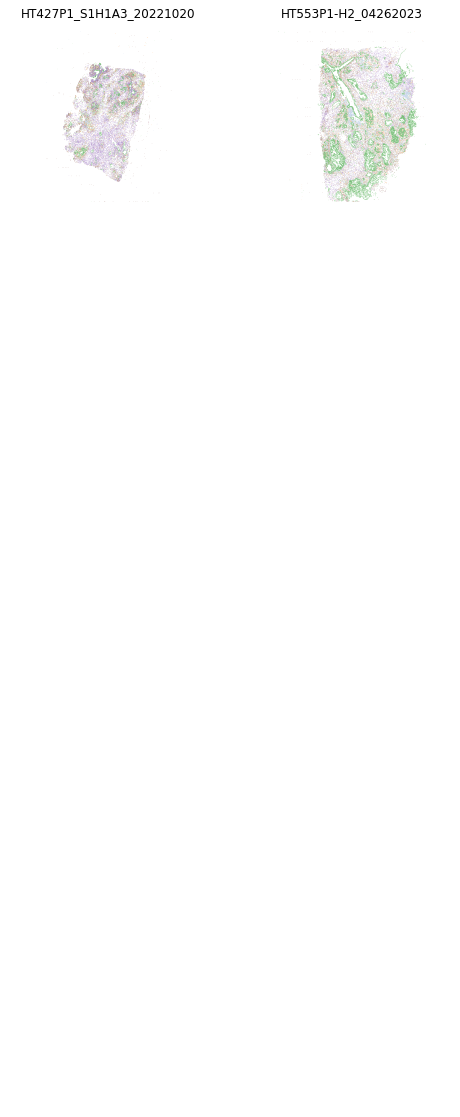

In [33]:


ncols = 2
nrows = (len(name_to_features) // ncols) + 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 4, nrows * 4))

queue = [
 'HT427P1_S1H1A3_20221020 | HT427P1_S1H1A3_20221020',
 'HT553P1-H2_04262023 | HT553P1-H2_04262023']
for i in range(nrows):
    for j in range(ncols):
        ax = axs[i, j]
        if len(queue):
            name = queue.pop(0)
            f = name_to_features[name]
            sns.scatterplot(data=f, x='col', y='row', hue='cell_type', s=.1, hue_order=order,
                            ax=ax, palette='tab20')
            ax.invert_yaxis()
            ax.axis('equal')
            ax.axis('off')
            ax.set_title(name.split(' | ')[0])

            leg = ax.get_legend()
            if leg is not None:
                leg.remove()
            
    
        else:
            ax.axis('off')
            
            

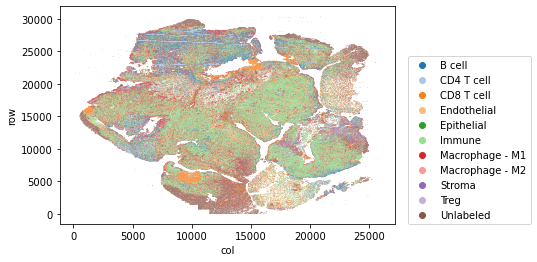

In [30]:
name = next(iter(name_to_features.keys()))
f = name_to_features[name]
sns.scatterplot(data=f, x='col', y='row', hue='cell_type', s=.2, hue_order=order, palette='tab20')
plt.legend(loc=(1.04, 0))

In [31]:
combined['omero_dataset'] = [n.split(' | ')[0] for n in combined['name']]
combined['omero_image'] = [n.split(' | ')[1] for n in combined['name']]
combined['row'], combined['col'] = [int(x) for x in combined['row']], [int(x) for x in combined['col']]

In [32]:
combined.to_csv('/diskmnt/Projects/Users/estorrs/sandbox/HT397B1_serial_features.txt', sep='\t', index=False)

In [26]:
name_to_features.keys()

dict_keys(['HT110B1_S1H4 | HT110B1_S1H4', 'HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff', 'HT171B1-S1H9A1-4_right_05122023 | HT171B1-S1H9A1-4_right_05122023.ome.tiff', 'HT206B1_H1 | HT206B1_H1', 'HT206B1_H1_06252022 | HT206B1_H1_06252022', 'HT206B1_S1H2L4_20221028 | HT206B1_S1H2L4_20221028', 'HT243B1-S1H4A4_04192023 | HT243B1-S1H4A4_04192023', 'HT243B1-S1H4A4_left_05122023 | HT243B1-S1H4A4_left_05122023.ome.tiff', 'HT243B1-S1H4A4_right_05122023 | HT243B1-S1H4A4_right_05122023.ome.tiff', 'HT243B1_S1H4 | HT243B1_S1H4', 'HT271B1-S1H6A5_04192023 | HT271B1-S1H6A5_04192023', 'HT271B1-S1H6A5_left_05122023 | HT271B1-S1H6A5_left_05122023.ome.tiff', 'HT271B1-S1H6A5_right_05122023 | HT271B1-S1H6A5_right_05122023.ome.tiff', 'HT271B1_S1H3A5_02172023 | HT271B1_S1H3A5_02172023', 'HT297B1_H1_08042022 | HT297B1_H1_08042022', 'HT305B1_S1H1 | HT305B1_S1H1', 'HT308B1-S1H5A4_04192023 | HT308B1-S1H5A4_04192023', 'HT308B1-S1H5A4_left_05122023 | HT308B1-S1H5A4_left_05122023.ome.tif

In [31]:
import anndata

In [32]:
for name, f in name_to_features.items():
    print(name)    
    val_cols = [c for c in f.columns if '_fraction' in c]
    meta = f[[c for c in f.columns if c not in val_cols]]
    meta = meta.set_index('label')
    a = anndata.AnnData(X=f[val_cols].values.astype(np.float32), obs=meta)
    a.var.index = val_cols
    
    a.uns['thresholds'] = channel_thresholds[name]
    a.uns['gating_strategy'] = json.dumps(gating_strategy)
    
    a.obsm['spatial'] = meta[['col', 'row']].values
    
    root = mapping[name]['img'].split('/level_')[0]

    level_4 = os.path.join(root, 'level_4')
    Path(level_4).mkdir(parents=True, exist_ok=True)
    
    identifier = name.split(' | ')[-1].replace('.ome.tiff', '')
    a.write_h5ad(os.path.join(level_4, f'{identifier}.h5ad'))
    f.to_csv(os.path.join(level_4, f'{identifier}.txt'), sep='\t')
    
    print(os.path.join(level_4, f'{identifier}.h5ad'))
    

HS-18-11250-1B_06102023 | HS-18-11250-1B_06102023.ome.tiff


/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/06102023_HS-18-11250-1B_TOP_HS-19-6647-1B_BTM/level_4/HS-18-11250-1B_06102023.h5ad
HS-18-6934-2A_06062023 | HS-18-6934-2A_06062023.ome.tiff
/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/06062023_GBM_HS-18-6934-2A_TOP_HS-19-14816-1J_BTM/level_4/HS-18-6934-2A_06062023.h5ad
HS-19-14816-1J_06062023 | HS-19-14816-1J_06062023.ome.tiff
/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/06062023_GBM_HS-18-6934-2A_TOP_HS-19-14816-1J_BTM/level_4/HS-19-14816-1J_06062023.h5ad
HS-19-6647-1B_06102023 | HS-19-6647-1B_06102023.ome.tiff
/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/06102023_HS-18-11250-1B_TOP_HS-19-6647-1B_BTM/level_4/HS-19-6647-1B_06102023.h5ad


In [37]:
# !scp /diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041223_BRCA_HT397B1-S1H3A1-U22/level_4/HT397B1_S1H1A3U22_04122023.h5ad glacier:/data/multiplex_imaging/codex/htan/brca/041223_BRCA_HT397B1-S1H3A1-U22/level_4/HT397B1_S1H1A3U22_04122023.h5ad
# !scp /diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/040623_BRCA_HT397B1-U31/level_4/HT397B1_S1H1A3U31_04062023.h5ad glacier:/data/multiplex_imaging/codex/htan/brca/040623_BRCA_HT397B1-U31/level_4/HT397B1_S1H1A3U31_04062023.h5ad
# !scp /diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_4/HT397B1_U12_03172023.h5ad glacier:/data/multiplex_imaging/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_4/HT397B1_U12_03172023.h5ad
# !scp /diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/031623_BRCA_HT397B1-U2/level_4/HT397B1_U2_03162023.h5ad glacier:/data/multiplex_imaging/codex/htan/brca/031623_BRCA_HT397B1-U2/level_4/HT397B1_U2_03162023.h5ad
# # !scp /diskmnt/Projects/Users/estorrs/multiplex_data/ glacier:/data/multiplex_imaging
    
    
    
    

HT397B1_S1H1A3U22_04122023.h5ad               100%   67MB 107.1MB/s   00:00    
HT397B1_S1H1A3U31_04062023.h5ad               100%   52MB 102.2MB/s   00:00    
HT397B1_U12_03172023.h5ad                     100%   79MB 103.6MB/s   00:00    
HT397B1_U2_03162023.h5ad                      100%   88MB 104.8MB/s   00:00    
